# Under the Hood: Training a Digit Classifier


In [1]:
#| echo: false
#| warning: false
#| error: false
#| include: false
import Pkg; Pkg.activate(".")
using MLDatasets
using Images
using Plots
using Statistics
using Flux

  Activating new project at `C:\Users\rhys-\OneDrive\University\Old\Documents\GitHub\Deep-Learning-for-Coders-Julia\Deep-learning-for-coders-julia`


[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]


┌ Warning: Module AbstractFFTsChainRulesCoreExt with build ID fafbfcfd-701e-0eae-0000-29b73c96fa9d is missing from the cache.
│ This may mean AbstractFFTsChainRulesCoreExt [07c0d231-1838-56d6-9ec8-835e5b9b958e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1752
┌ Error: Error during loading of extension AbstractFFTsChainRulesCoreExt of AbstractFFTs, use `Base.retry_load_extensions()` to retry.
└ @ Base loading.jl:1200


┌ Warning: Module FFTW with build ID fafbfcfd-0715-8e42-0000-29b4bf674291 is missing from the cache.
│ This may mean FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1752


┌ Warning: Module FFTW with build ID fafbfcfd-0715-8e42-0000-29b4bf674291 is missing from the cache.
│ This may mean FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1752
[ Info: Skipping precompilation since __precompile__(false). Importing Images [916415d5-f1e6-5110-898d-aaa5f9f070e0].


[ Info: Precompiling ImageFiltering [6a3955dd-da59-5b1f-98d4-e7296123deb5]


┌ Warning: Module FFTW with build ID fafbfcfd-0715-8e42-0000-29b4bf674291 is missing from the cache.
│ This may mean FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1752


[ Info: Skipping precompilation since __precompile__(false). Importing ImageFiltering [6a3955dd-da59-5b1f-98d4-e7296123deb5].
[ Info: Precompiling FFTViews [4f61f5a4-77b1-5117-aa51-3ab5ef4ef0cd]


┌ Warning: Module FFTW with build ID fafbfcfd-0715-8e42-0000-29b4bf674291 is missing from the cache.
│ This may mean FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1752


[ Info: Skipping precompilation since __precompile__(false). Importing FFTViews [4f61f5a4-77b1-5117-aa51-3ab5ef4ef0cd].


[ Info: Precompiling ImageSegmentation [80713f31-8817-5129-9cf8-209ff8fb23e1]


┌ Warning: Module ImageFiltering with build ID ffffffff-ffff-ffff-0000-3b6fedd9af3a is missing from the cache.
│ This may mean ImageFiltering [6a3955dd-da59-5b1f-98d4-e7296123deb5] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1752
[ Info: Skipping precompilation since __precompile__(false). Importing ImageSegmentation [80713f31-8817-5129-9cf8-209ff8fb23e1].


This chapter utilises the topic of computer vision as a vehicle for introducing a number of fundamental tools and concepts for deep learning.

These tools and concepts include:

-   Roles of arrays and tensors and how broadcasting can be used to operate on these structures.
-   Stochastic gradient descent and how it can be used to train a model.
-   Choosing appropriate loss functions for a basic classification task.
-   The role of mini-batches in training a model.
-   The math that a basic neural network is utilising.

## Pixels: The Foundations of Computer Vision

In an effort to understand the internals of computer vision models, we first begin by discussing how computers handle images. The dataset used to illustrate this concept will be [MNIST](https://en.wikipedia.org/wiki/MNIST_database "MNIST dataset").

In the original book, the FastAI vision library will download the MNIST dataset to your computer and place the images into separate folders depending upon the identity of the image and its position in the train or validation sets. For simplicity here we use the `MLDatasets` package instead.

Below we can see a visualisation of two examples of the images found within these datasets. The images are either a handwritten three or a seven.


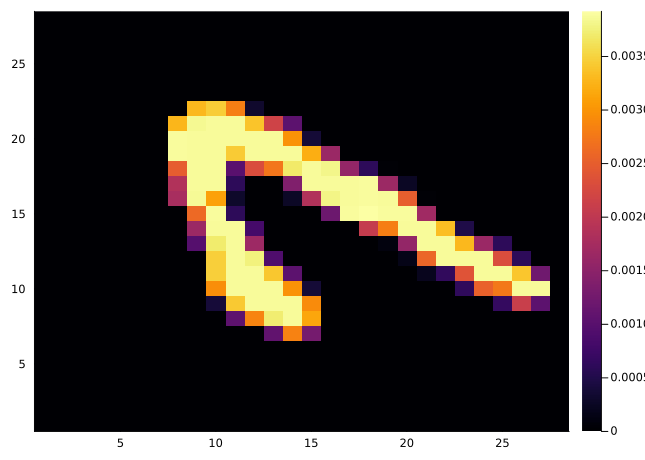

In [2]:
dataset = MLDatasets.MNIST(:train)


three_features = (dataset.features[:,:,dataset.targets .== 3]) / 255
seven_features = (dataset.features[:,:,dataset.targets .== 7]) / 255


stacked_sevens = permutedims(seven_features, [1, 2, 3])
stacked_threes = permutedims(three_features, [2, 1, 3])




Plots.heatmap(stacked_sevens[:,:,1])

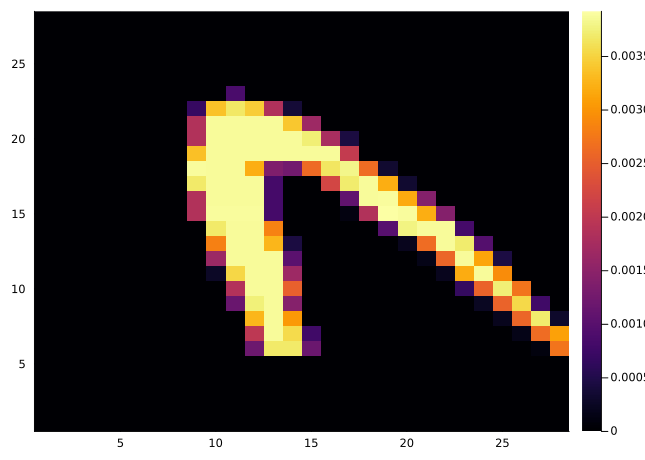

In [3]:
Plots.heatmap(seven_features[:,:,9])

In a computer everything is represented using numbers and images are no exception. Here we see a small section of the image of a three. Each of the numbers within this array is representative of a pixel within the image.


In [4]:
three_features[4:10,4:10,1]

7×7 Matrix{Float32}:
 0.0  0.0  0.0  0.0          0.0         0.0         0.0
 0.0  0.0  0.0  0.0          0.0         0.0         0.0
 0.0  0.0  0.0  0.0          0.0         0.0         0.0
 0.0  0.0  0.0  0.0          0.0         0.0         0.0
 0.0  0.0  0.0  0.0          0.0         0.0         0.0
 0.0  0.0  0.0  0.0          0.0         0.0         0.0
 0.0  0.0  0.0  0.000661284  0.00273741  0.00167628  6.15148f-5

## First try: Pixel Similarity

For a first approach to solving the issue of distinguishing between a photo of a three or a seven, we begin by calculating the average pixel value of every pixel for both a 3 and a 7. This provides us two group averages that we can consider to be the 'ideal' 3 and 7. Then a comparsion between a given image and these two averages will help us classify said image.

::: callout-tip
## Baseline

A baseline model is a simple model that you are confident will perform reasonably well. Ideally these models should be easy to implement and test such that we have the ability to reference the performance of our new and more complex models against. This is an important place to begin as without a baseline in place we can't really judge if our new and fancy models are actually performing that well.
:::

Let's begin by calculating the average of the pixel values for our 3s and 7s.

For every pixel in an image, we would like to calculate the average value of that pixel over all the images of our 3s or 7s. If we were beginning with single images we would need to combine all of our images into a single three-dimensional tensor. Fortunately, the `MLDatasets` library provides us with a tensor that is already in this format.

Below we can see what the 'average' 3 and 7 images look like.


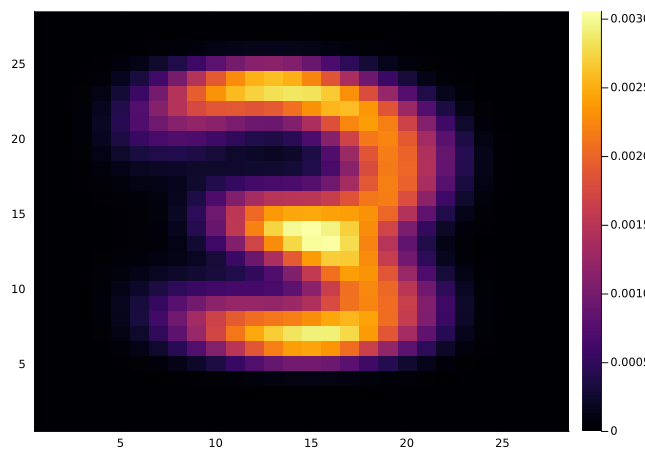

In [5]:
mean3 = mean(stacked_threes, dims=3)
mean7 = mean(stacked_sevens, dims=3)

Plots.heatmap(mean3[:,:,1])

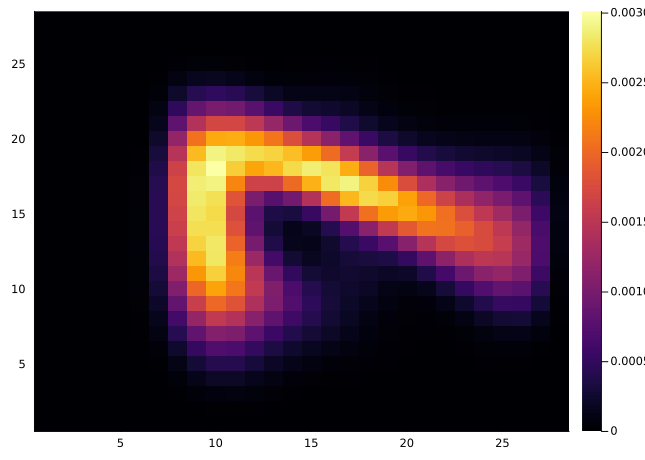

In [6]:
Plots.heatmap(mean7[:,:,1])

Here, we select a random single image from the dataset to serve as a representative image to test our model against.


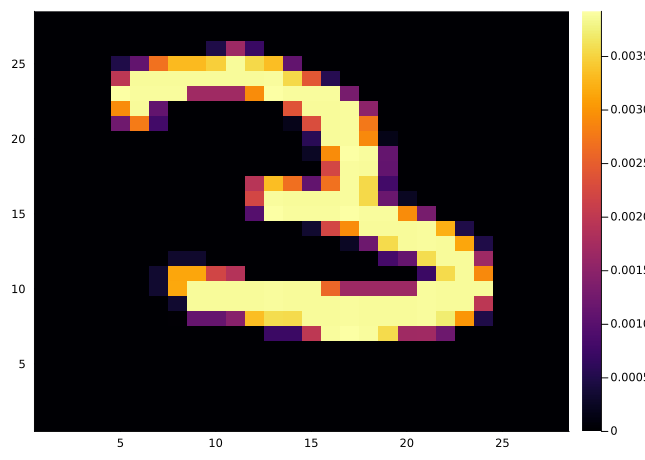

In [7]:
a_3 = stacked_threes[:, :, 20]
a_7 = stacked_sevens[:, :, 20]

Plots.heatmap(a_3)

So how do we quantify the distance of a given image from our ideal 3? There are two ways we can approach this issue, we can take the mean of the absolute value of the differences between each pixel, this is referred to as the mean absolute difference (L1 norm). Alternatively, we could take the mean of the squared differences between each pixel and then apply a square root (to undo the squaring). This is called the root mean squared error (RMSE or L2 norm).

Below we see two functions that accept two tensors and calculate either the mean absolute distance or root mean squared error.


In [8]:
"Calculates the average absolute distance between two tensors"
function mean_abs_mnist_distance(a, b)
    return mean(abs.(a .- b), dims=(1,2))
end

"Calculates the mean of the squared distance between two tensors"
function sqrt_mean_mnist_distance(a, b)
    return sqrt(mean((a .- b).^2))
end

dist_3_abs = mean_abs_mnist_distance(a_3, mean3)
dist_7_abs = mean_abs_mnist_distance(a_7, mean3)

println("Distance from 3: $dist_3_abs ")
println("Distance from 7: $dist_7_abs")

Distance from 3: [0.00065970985;;;] 
Distance from 7: [0.00071201497;;;]


In [9]:
dist_3_sqrt = sqrt_mean_mnist_distance(a_3, mean3)
dist_7_sqrt = sqrt_mean_mnist_distance(a_7, mean3)

println("Distance from 3: ", dist_3_sqrt)
println("Distance from 7: ", dist_7_sqrt)

Distance from 3: 0.0011778519
Distance from 7: 0.0012536361


Fortunately, Flux provides us with both of this loss functions already and they can be called as seen below.


In [10]:
@show Flux.Losses.mae(a_3, mean3)

@show sqrt(Flux.Losses.mse(a_3, mean3));

Flux.Losses.mae(a_3, mean3) = 0.00065970985f0
sqrt(Flux.Losses.mse(a_3, mean3)) = 0.0011778519f0


## Computing Metrics Using Broadcasting

::: callout-note
A metric is a numeric value calculated based upon our models predictions and the correct labels in our dataset, that tells us how well our model is performing.
:::

Although both mean squared error and mean absolute error could very well serve as our metrics of choice, these two values are not very interpretable to most people. Thus, the use of accuracy as a metric in the domain of classification models is more often the norm.

Normally, the metric is calculated based on the performance of our model on the validation dataset, however in our pixel similarity model there is no trained component thus there isn't really a risk of overfitting here. To keep with our conventions we will still use a validation set regardless in this problem.

To create a validation set, we remove a portion of the data from training entirely, such that the model doesn't have an opportunity to see this data. Fortunately, the creators of the MNIST dataset have pre-allocated a portion of the images into training and validation sets and the `MLDatasets` library has presented this dataset accordingly. It is important to note that the same preparation steps we applied to the training data has been applied to the validation data.


In [11]:
valid = MLDatasets.MNIST(:test)
valid_three_features = (valid.features[:,:,valid.targets .== 3]) / 255;
valid_seven_features = (valid.features[:,:,valid.targets .== 7]) / 255;
valid_seven_features = permutedims(valid_seven_features, [1, 2, 3]);
valid_three_features = permutedims(valid_three_features, [2, 1, 3]);

In [12]:
function prepare_data(dataset)
    # select 3s and 7s
    three_feats = (dataset.features[:,:,dataset.targets .== 3]) / 255
    seven_feats = (dataset.features[:,:,dataset.targets .== 7]) / 255

    # rearrange dimensions
    three_feats = permutedims(three_feats, [1, 2, 3])
    seven_feats = permutedims(seven_feats, [2, 1, 3])
    return three_feats, seven_feats
end

prepare_data (generic function with 1 method)

In [13]:
tft, sft = prepare_data(valid)

size(tft) == size(valid_three_features)

true

Our aim now is to create a function called `is_3` that will determine if some image is a 3 or a 7. It will accomplish this by determining which of our two average 3 and 7 images this selected image is closer to. To judge this distance between images we will begin by defining a function that quantifies the distance between two images using the mean absolute error.


In [14]:
function mnist_distance(a, b)
    return mean(abs.(a .- b), dims=(1,2))
end

mnist_distance (generic function with 1 method)

We can then apply the following logic to determine if an image is a three or a seven. If the distance between the select image and the average 3 is less than the distance from the average 7 then the image is a three. Below we see this expressed in a function that accepts an image and performs this calculation.


In [15]:
function is3(x)
    return mnist_distance(x, mean3) .< mnist_distance(x, mean7)
end

is3 (generic function with 1 method)

From this simple baseline model we can see that it is performing quite well, however threes and sevens are quite distinct looking images and only represent two out of the possible ten digits! Perhaps it is time to develop a system that is capable of performing actual learning before we progress to this next stage.


In [16]:
accuracy_3s = mean(is3(valid_three_features))
accuracy_7s = 1 - mean(is3(valid_seven_features))

println("Accuracy of 3s: ", accuracy_3s)
println("Accuracy of 7s: ", accuracy_7s)

Accuracy of 3s: 0.9881188118811881
Accuracy of 7s: 0.9970817120622568


## Stochastic Gradient Descent

Arthur Samuel theorised that machine learning would be possible if there existed a means of automatically testing the effectiveness of a given weight assignment and then altering these weights such that the performance of the system could be maximised. If this procedure could be made automatic then he believed that a machine could truly learn from its experiences. If we wish to expand upon and improve our digit classification model we will have to employ Arthurs beliefs and create a system that has both weight assignments and a manner upon which these weights can be automatically improved.

As opposed to our original strategy of examining the difference between a given image and an 'idealised' image, we will instead consider every individual pixel within an image and arrange a set of weights for each pizel, such that the highest weights correspond to pixels most likely to be black for a given category of digit.

Our aim is to find specific values for our weight vector ($W$) such that the result of our function is high for the digit it represents and low for those it does not.

Here are the steps we will need to employ in order to change our classification function into a machine learning classifier:

1.  Initialise our weights.
2.  For each image, use our weights to predict the identity of the image (3 or 7).
3.  From these predictions quantify the performance of the model (i.e the loss).
4.  Calculate the gradient, from which we can evalute how changing each weight value would influence our loss.
5.  Change the weights (step) based upon the above calculation.
6.  Return to step 2 and repeat the entire process.
7.  Iterate until you decide you are happy with the model or have run out of time.


```{mermaid}
flowchart LR 
    A(init) --> B(predict)
    B --> C(loss)
    C --> D(gradient)
    D --> E(step)
    E --> F(stop)
    E --> B
```


Before we begin applying these steps to our MNIST example, lets examine a simpler case of a quadratic that we can use as an example loss function and a parameter x which will stand as a weight parameter for our function.


In [17]:
"Accepts a number and squares it"
function squared(x)
    return x^2 # <1>
end 

squared(2)

4

1.  Note that in Julia exponents are denoted by the caret symbol (\^) as opposed to the double asterix present in python.


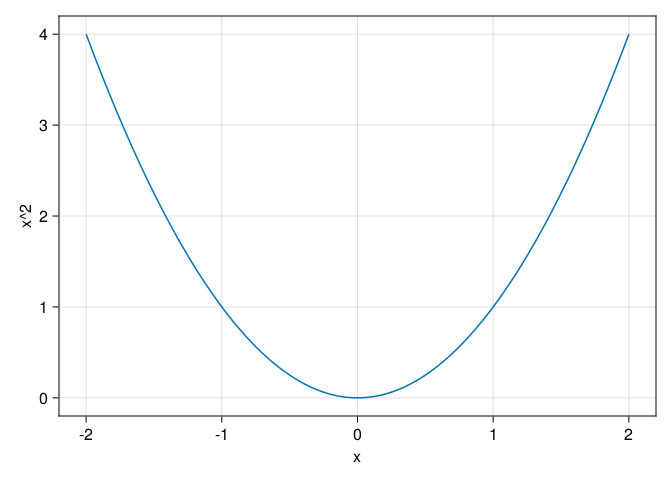

In [18]:
using CairoMakie

f = Figure()
ax = CairoMakie.Axis(f[1, 1],
    xlabel = "x",
    ylabel = "x^2")
x = range(-2, 2, length=100)
y = squared.(x)
lines!(ax, x, y)
f

### Calculating gradients

Calculus provides us with a mechanism for performance optimising. We can quickly evaluate how our loss will response to small adjustments of our parameters. In short, calculating gradients will tell us how much we should change our weights to improve our models.

Calculating gradients in `Flux` is quite abit different to `Pytorch`.

Recall that our squared function we defined earlier:

$$
f(x) = x^2
$$

We know that the derivative of this expression should be:

$$
f'(x) = 2x
$$

And below we examine how to test this using `Flux`.


In [19]:
xt = 3 
@show yt = squared(xt) # <1>

grad = gradient(xt) do x # <2> 
    yt = squared(x) # <3>
end

println("f(3) = $yt and f'(3) = $grad")

yt = squared(xt) = 9


f(3) = 9 and f'(3) = (6.0,)


1.  Here we evaluate our initial function at $x = 3$ to see its output.
2.  We define a variable `grad` which will contain the gradient of the expression we want to take the derivative of. We pass the parameter we want to take the derivative with respect to inside the `gradient` function and provide an alias for this variable with the do block. If we wanted to take the derivative with respect to multiple variables we can simply pass multiple variables and assign aliases to each.
3.  We then evaluate the expression and end the do block so we can examine the gradients.

### Stepping with a Learning Rate

Deciding how we will change our parameters based upon the gradients we just calculated is an important part of the deep learning process. Most often, this process is implemented through the use of learning rates, which are simply small numbers (usually between 0.001 and 0.1) that we multiply our gradients by. We can refer to this act of using a learning rate multipled by our gradients to change our parameters as 'stepping' through the use of an optimisation step.


In [20]:
@show xt
lr = 0.001 # <1>

@show xt -= grad[1] * lr; # <2>

xt = 3
xt -= grad[1] * lr = 2.994


1.  Here we define our learning rate, i.e some small number.
2.  Here we update our imaginary weight value using `-=` by the value of our calculating gradient multiplied by our learning rate.

### An End-to-End SGD Example

To fully illustrate this process, lets consider a contrived sample. We imagine that we're measuring the speed of a roller coaster as it traverses the top of a hill, the speed will start off quite fast but then decrease as it moves up the hill where it will be its slowest then it will increase again once it passes.


In [21]:
time = collect(0:19) # <1>

speed = randn(20) .* 3 .+ 0.75 .* (time .- 9.5) .^2 .+ 1; # <2>


1.  Here we define our x variable, time as being evenly spaced integers between 0 and 20. Note the `0:20` syntax in julia defines a range and the `collect` function returns an array of the objects within a given range.
2.  Here we apply a formula roughly quadratic in shape with some stochastic noise added.


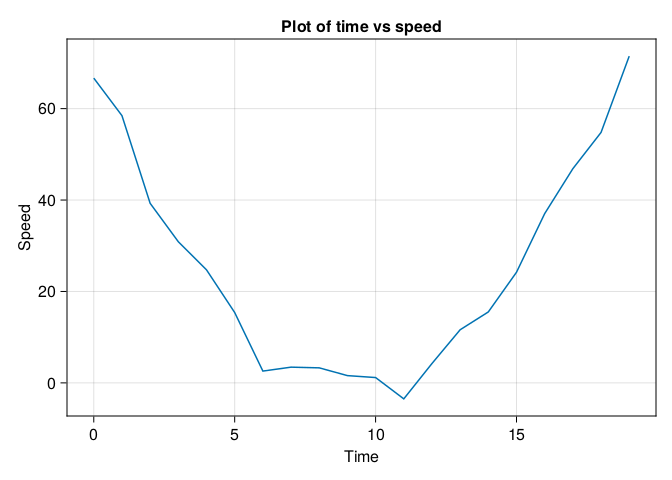

In [22]:
#| echo: false
#| 
f = Figure()
ax = CairoMakie.Axis(f[1, 1],
    title = "Plot of time vs speed",
    xlabel = "Time",
    ylabel = "Speed")
x = time
y = speed
lines!(ax, x, y)
f

Our aim here is to build a model of how the speed of the rollercoaster will change with time. We can use what we know about SGD already to try and find a function that will fit our data, to simply this process we will enforce a quadratic form to our initial function:

$$
a * \text{time}^2 + (b *\text{time}) + c
$$


In [23]:
"""
A function that models speed as a function of time.

# Arguments
- `t::Vector{Float64}`: a vector of time values.
- `params::Vector{Float64}`: a vector of three randomly initialised parameter values.
"""
function speed_model(t, params)
    return @. params[1] * (t ^ 2) + (params[2] * t) + params[3]
end

speed_model

By enforcing this structure onto our problem, we only need to search for the optimal values for three parameters. This greatly simplifies the goal of searching for the best quadratic function that will fit our data.

In order to quantify what we mean by 'best' we need to select a loss function. This function will return a value based upon our models predictions and the ground truth values. By convention this value will be lower when our predictions are better i.e closer to the labels and larger when they are further away. For continuous data, like the data we are using here it is common to use the mean squared error as a loss function.


In [24]:
mean_squared_error(preds, targets) = mean((preds .- targets) .^2)

mean_squared_error (generic function with 1 method)

Recall that we originally described a seven step process for our SGD loop, lets begin to follow along with those steps.

#### Step 1: Initialise our parameters


In [25]:
params = [randn(), randn(), randn()]

3-element Vector{Float64}:
 -0.36347623248580097
  0.9783086209357734
 -0.9393847492777065

#### Step 2: Calculate our predictions


In [26]:
preds = speed_model(time, params)

20-element Vector{Float64}:
   -0.9393847492777065
   -0.3245523608277341
   -0.43667243734936356
   -1.2757449788425945
   -2.8417699853074283
   -5.134747456743865
   -8.1546773931519
  -11.90155979453154
  -16.37539466088278
  -21.576181992205626
  -27.503921788500072
  -34.158614049766115
  -41.54025877600376
  -49.64885596721302
  -58.48440562339387
  -68.04690774454633
  -78.33636233067038
  -89.35276938176604
 -101.0961288978333
 -113.56644087887217

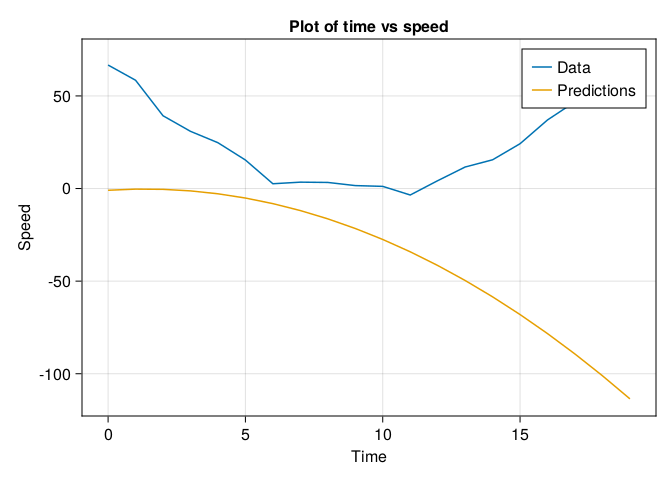

In [27]:
#| echo: false
f = Figure()
ax = CairoMakie.Axis(f[1, 1],
    title = "Plot of time vs speed",
    xlabel = "Time",
    ylabel = "Speed")
x = time
y = speed
lines!(ax, x, y, label="Data")
lines!(ax, x, preds, label="Predictions")
axislegend()
f

#### Step 3: Calculate our loss


In [28]:
@show loss = mean_squared_error(preds, speed)

loss = mean_squared_error(preds, speed) = 6255.165135301322


6255.165135301322

#### Step 4: Calculate the gradients


In [29]:
gradients = gradient(params[1], params[2], params[3]) do x,y,z
    preds = x .* (time .^2) .+ (y .* time) .+ z
    loss = mean_squared_error(preds, speed)
    end

println(gradients)

println(gradients .* 1e-5)

(-25073.20451558565, -1585.8425266161241, -124.04405678060576)
(-0.2507320451558565, -0.01585842526616124, -0.0012404405678060576)


#### Step 5: Step the weights


In [30]:
lr = 1e-5
params .-= lr .* gradients
println(params)

gradients = zeros(3) # <1>

[-0.11274418732994446, 0.9941670462019346, -0.9381443087099005]


3-element Vector{Float64}:
 0.0
 0.0
 0.0

1.  Remembering to zero out our gradients is an important step in a training loop otherwise the gradients we calculate will clash.

Lets re-examine our preds after one epoch. We can see that our predictions are getting abit closer after one training loop!


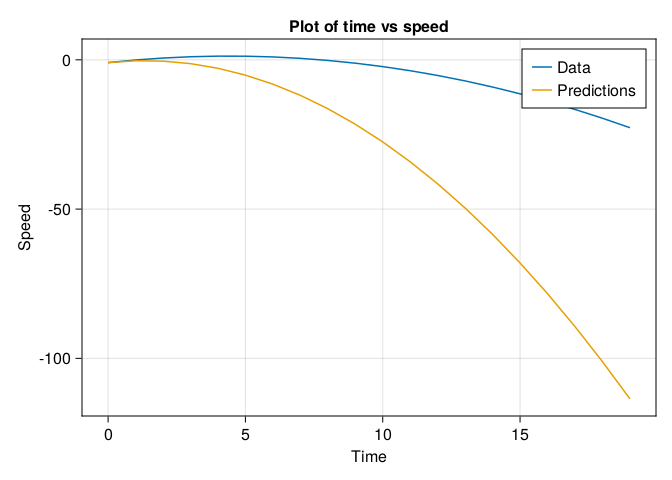

In [31]:
#| echo: false
f = Figure()
ax = CairoMakie.Axis(f[1, 1],
    title = "Plot of time vs speed",
    xlabel = "Time",
    ylabel = "Speed")
x = time
y = speed_model(time, params)
lines!(ax, x, y, label="Data")
lines!(ax, x, preds, label="Predictions")
axislegend()
f

Lets repeat this process a few times and see how our predictions improve.


In [32]:
function apply_step(params, lr=1e-5)
    preds = speed_model(time, params)
    @show loss = mean_squared_error(preds, speed)

    gradients = gradient(params[1], params[2], params[3]) do x,y,z
        preds = x .* (time .^2) .+ (y .* time) .+ z
        loss = mean_squared_error(preds, speed)
    end

    
    params .-= lr .* gradients
    gradients = zeros(3)
    return preds
end

for i in range(1, 10)
    apply_step(params)
end

loss = mean_squared_error(preds, speed) = 1726.3125967311094


loss = mean_squared_error(preds, speed) = 869.3094250760441
loss = mean_squared_error(preds, speed) = 707.1323131563696
loss = mean_squared_error(preds, speed) = 676.4375165871306
loss = mean_squared_error(preds, speed) = 670.623191313873
loss = mean_squared_error(preds, speed) = 669.517012234511
loss = mean_squared_error(preds, speed) = 669.3017592656403
loss = mean_squared_error(preds, speed) = 669.2550977682567
loss = mean_squared_error(preds, speed) = 669.2403399642608
loss = mean_squared_error(preds, speed) = 669.2316203505126


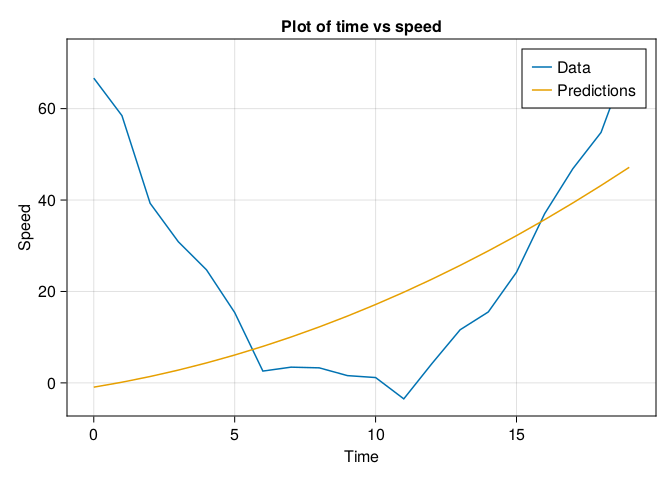

In [33]:
#| echo: false
f = Figure()
ax = CairoMakie.Axis(f[1, 1],
    title = "Plot of time vs speed",
    xlabel = "Time",
    ylabel = "Speed")
x = time
y = speed_model(time, params)
lines!(ax, time, speed, label="Data")
lines!(ax, x, y, label="Predictions")
axislegend()
f

Although not perfect, we can see our model is approaching the shape of our original data after only ten epochs.